# Spatial Preprocessing and Clustering

Load aligned image data (if available), preprocess, and cluster spatial data.

## Imports & Settings

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import time
import itertools
import scipy
import scanpy as sc
import seaborn as sb
import pandas as pd
import numpy as np
import corescpy as cr

# Run Information
# print(f"\n\n{'=' * 80}\ncoreSCpy Version: {cr.__version__}\n\n")
# print(f"\n\n{'=' * 80}\nDate/Time: {time.time()}\n\n")

# Computing Resources
gpu = False
sc.settings.n_jobs = 8
# sc.settings.max_memory = 150

# Display
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100
pd.options.display.max_rows = 500
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

# Panel & Column Names (from Metadata & To Be Created)
panel = "TUQ97N"  # or "XR4UZH"
suffix = ""  # no file suffix for object h5ad file (main object)

# Samples/Runs
use_prior_clustering = False
run = None  # just look for `samples` in all Xenium runs
samples = ["50217A", "50336C"]
# run = "CHO-001"  # run all from this run; so don't have to specify samples
# samples = "all"  # use samples = "all" with run = something for all from run
capitalize_sample = True if panel == "TUQ97N" else False

# Automated Annotation Options
file_ann = os.path.join(os.path.expanduser("~"),
                        "corescpy/examples/markers_lineages.csv")
# file_ann = None  # to skip marker-based annotation
col_assignment = "Bin"  # all clustering versions use same annotation column
col_assignment = None  # column in annotation file whose labels to use
# col_assignment = ["group", "Bin", "Bin"]  # (order corresponds to res_list)

# Main Directories
usr_write_rel_path = f"{os.getlogin()}/data/shared-xenium-library"
d_hpc = "/mnt/cho_lab" if os.path.exists(
    "/mnt/cho_lab") else "/mnt/data1" if os.path.exists(
        "/mnt/data1") else "/sc/arion/projects/untreatedIBD"  # HPC path
d_nfs = os.path.join(d_hpc, "nfs-data-registries/bb-xenium-registry") if (
    os.path.exists(os.path.join(
        d_hpc, "nfs-data-registries/bb-xenium-registry"))) else os.path.join(
            d_hpc, "cache/nfs-data-registries/xenium-registry") if (
                os.path.exists(os.path.join(
                    d_hpc, "cache/nfs-data-registries/xenium-registry"))
                ) else os.path.join(
                    d_hpc, "chobiolab-core/shared-xenium-library")
d_usr = os.path.join(d_hpc, "disk2", usr_write_rel_path) if os.path.exists(
    os.path.join(d_hpc, "disk2", usr_write_rel_path)) else os.path.join(
        d_hpc, usr_write_rel_path)
d_img = os.path.join(d_hpc, f"cache/tissue-registry/xenium/{panel}") if (
    "arion" in d_hpc) else os.path.join(
        d_hpc, f"cache/bb-nfs-data-registries/tissue-registry/xenium/{panel}"
        ) if ("bb-" in d_nfs) else os.path.join(
            d_hpc, f"nfs-data-registries/tissue-registry/xenium/{panel}")
file_mdf = os.path.join(d_usr, f"samples_{panel}.csv")  # metadata file path

# Overall Output Directory
out_dir = os.path.join(d_usr, f"outputs/{panel}/nebraska")

# Preprocessing Options
outlier_mads = {"n_counts": [1.25, None]}
# outlier_mads = None
kws_pp = dict(cell_filter_ngene=[3, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None], custom_thresholds=None,
              kws_scale=dict(max_value=10, zero_center=True),
              outlier_mads=outlier_mads, method_norm="log")  # preprocessing
# kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[15, None],
#               cell_filter_ngene=[3, None], gene_filter_ncell=[3, None],
#               gene_filter_ncounts=[3, None], custom_thresholds=None,
#               kws_scale=dict(max_value=10, zero_center=True),
#               method_norm="log")  # preprocessing old segmentation TUQ97N
# kws_pp = None   # if loading object already preprocessed

# Clustering Options
genes_subset = None  # use all genes in clustering
# genes_subset = list(pd.read_csv(file_ann).iloc[:, 0])  # only cell markers
kws_cluster = dict(kws_umap=dict(method="rapids" if gpu else "umap"),
                   genes_subset=genes_subset,  # use only markers
                   use_gpu=gpu, use_highly_variable=False)
# res_list = [1.5, 0.75, 0.5]  # resolutions (iterate clustering runs)
# min_dist_list = [0, 0.3, 0.5]  # distances (order corresponds to res_list)
# n_comps_list = [30, 30, 30]  # PCA components (order same as res_list)
res_list = [0.25]  # resolutions (iterate different clustering runs)
min_dist_list = [0.3]  # distances (order corresponds to res_list)
n_comps_list = [15]  # PCA components (order corresponds to res_list)
kws_clustering_spatial = None  # specify to perform spatial clustering
suffix_clustering_spatial = None  # column key for spatial clustering results
# ^ should parallel the parameters, like normal clustering does
# e.g., res0pt75_dist0pt3_npc30

## Setup

Get constants (e.g., column names in metadata), read metadata, create dictionary of clustering parameters (so can iterate across different clustering specifications to make multiple versions, e.g., at multiple resolutions) using `res_list`, `min_dist_list`, and `n_comps_list`, make any output directories (e.g., for processed objects, plots, find markers results, Xenium Explorer cluster files) if any don't exist yet, load data into objects, etc.

In [2]:
# Construct Directories (Less Likely to Need Changes)
# Mirror my file/directory tree in the `d_usr` directory
# out_dir = None  # don't write any outputs
out_subdir_markers = "find_markers"  # sub-directory under out_dir for markers
out_subdir_cluster = "explorer_files"  # sub-directory for cluster-cell ID csv
out_dir_plot = None if out_dir is None else os.path.join(out_dir, "plots")
print(f"\n\n\n{'=' * 80}\nDirectories\n{'=' * 80}\n\nHPC Entry Point (Cho): "
      f"{d_hpc}\nData: {d_nfs}\nMetadata: {file_mdf}\nImages: {d_img}\n"
      f"Object/Outputs:\n\t{out_dir} (objects)\n\t{out_dir_plot} (plots)\n\t"
      f"{os.path.join(out_dir, out_subdir_markers)} (markers)\n\n\n")

# Get/Set Constants
constants_dict = cr.get_panel_constants(panel_id=panel)
col_sample_id_o, col_sample_id, col_condition, col_inflamed, col_subject = [
    constants_dict[x] if x in constants_dict else None for x in [
        "col_sample_id_o", "col_sample_id", "col_condition",
        "col_inflamed", "col_subject"]]
col_stricture, key_stricture, col_f, col_tangram, col_segment, col_object = [
    constants_dict[x] if (x in constants_dict) else None for x in [
        "col_stricture", "key_stricture", "col_data_dir",
        "col_tangram", "col_segment", "col_object"]]

# Construct Clustering Keyword Dictionary
kws_clustering = {}
for i in zip(res_list, min_dist_list, n_comps_list):
    kws = {**kws_cluster}
    kws.update({"resolution": i[0], "n_comps": i[2],
                "kws_umap": {**kws_cluster["kws_umap"], "min_dist": i[1]}})
    suff = str(f"res{re.sub('[.]', 'pt', str(kws['resolution']))}_dist"
               f"{re.sub('[.]', 'pt', str(kws['kws_umap']['min_dist']))}"
               f"_npc{kws['n_comps']}")  # file path suffix
    kws_clustering.update({suff: kws})

# Read Metadata
metadata = cr.pp.get_metadata_cho(
    d_nfs, file_mdf, panel_id=panel, samples=samples, run=run,
    capitalize_sample=capitalize_sample)  # get metadata
c_inc = [col_sample_id_o, col_subject, col_condition, col_inflamed,
         col_stricture, col_segment, col_f]
print("\n\n", metadata[list(set(c_inc).intersection(metadata))])

# Annotation File
assign = pd.read_csv(file_ann).dropna(subset=col_assignment).set_index(
    "gene").rename_axis("Gene") if file_ann is not None else None
# assign = assign[~assign.Quality.isin([-1])]  # drop low-quality markers
if col_assignment is not None and isinstance(col_assignment, str):
    col_assignment = [col_assignment] * len(res_list)  # same for each version

# Create Objects
[os.makedirs(x, exist_ok=True) for x in [
    out_dir, out_dir_plot, os.path.join(out_dir, out_subdir_markers),
    os.path.join(out_dir, out_subdir_cluster)] if x]  # make out directories
kws_init = dict(col_sample_id=col_sample_id, col_subject=col_subject,
                col_cell_type=f"leiden_{list(kws_clustering.keys())[0]}")

# Checks
if use_prior_clustering is True and kws_pp is not None:
    raise ValueError("use_prior_clustering is True & `kws_pp` is not None. "
                     "To use prior object, set `kws_pp` to None.")

for i, s in enumerate(metadata.index.values):
    out = os.path.join(out_dir, f"{s}{suffix}.h5ad")  # object output path
    if os.path.exists(out):  # if processed object file exists...
        if kws_pp is not None:  # don't overwrite with new preprocessing
            raise ValueError(f"\n\nProcessed object already exists!\n{out}."
                             "\nSpecify different file suffix, or set "
                             "`kws_pp` to None to reload processed object.")
    elif kws_pp is None:  # if doesn't exist but pp parameters specified...
        raise ValueError(f"\n\nProcessed object doesn't exist!\n{out}.\n"
                         "Specify `kws_pp` to perform new proprocessing "
                         "or ensure processed object paths are correct.")




Directories

HPC Entry Point (Cho): /mnt/cho_lab
Data: /mnt/cho_lab/bb-xenium-registry
Metadata: /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/samples_TUQ97N.csv
Images: /mnt/cho_lab/bb-nfs-data-registries/tissue-registry/xenium/TUQ97N
Object/Outputs:
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/test (objects)
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/test/plots (plots)
	/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/nebraska/test/find_markers (markers)





                   stricture  subject_id   Condition sample_id inflammation
Sample                                                                    
Inflamed-50217A          no       50217    inflamed    50217A     inflamed
Uninflamed-50336C        no       50336  uninflamed    50336C   uninflamed


## Run

Ovewriting is not allowed. Move, rename, or delete previous object files to overwrite, or specify `suffix` above.



		Inflamed-50217A




<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bb-xenium-registry/outputs/TUQ97N/CHO-008/output-XETG00189__0015521__50217A-TUQ97N-EA__202404
         15__212906/cell_feature_matrix.h5                                                                         


Counts: Initial: table


	Observations: 1038830

	Genes: 469







 AnnData object with n_obs × n_vars = 1038830 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial'
    obsm: 'spatial'
    layers: 'counts' 

                gene_ids    feature_types   genome
ABCA7   ENSG00000064687

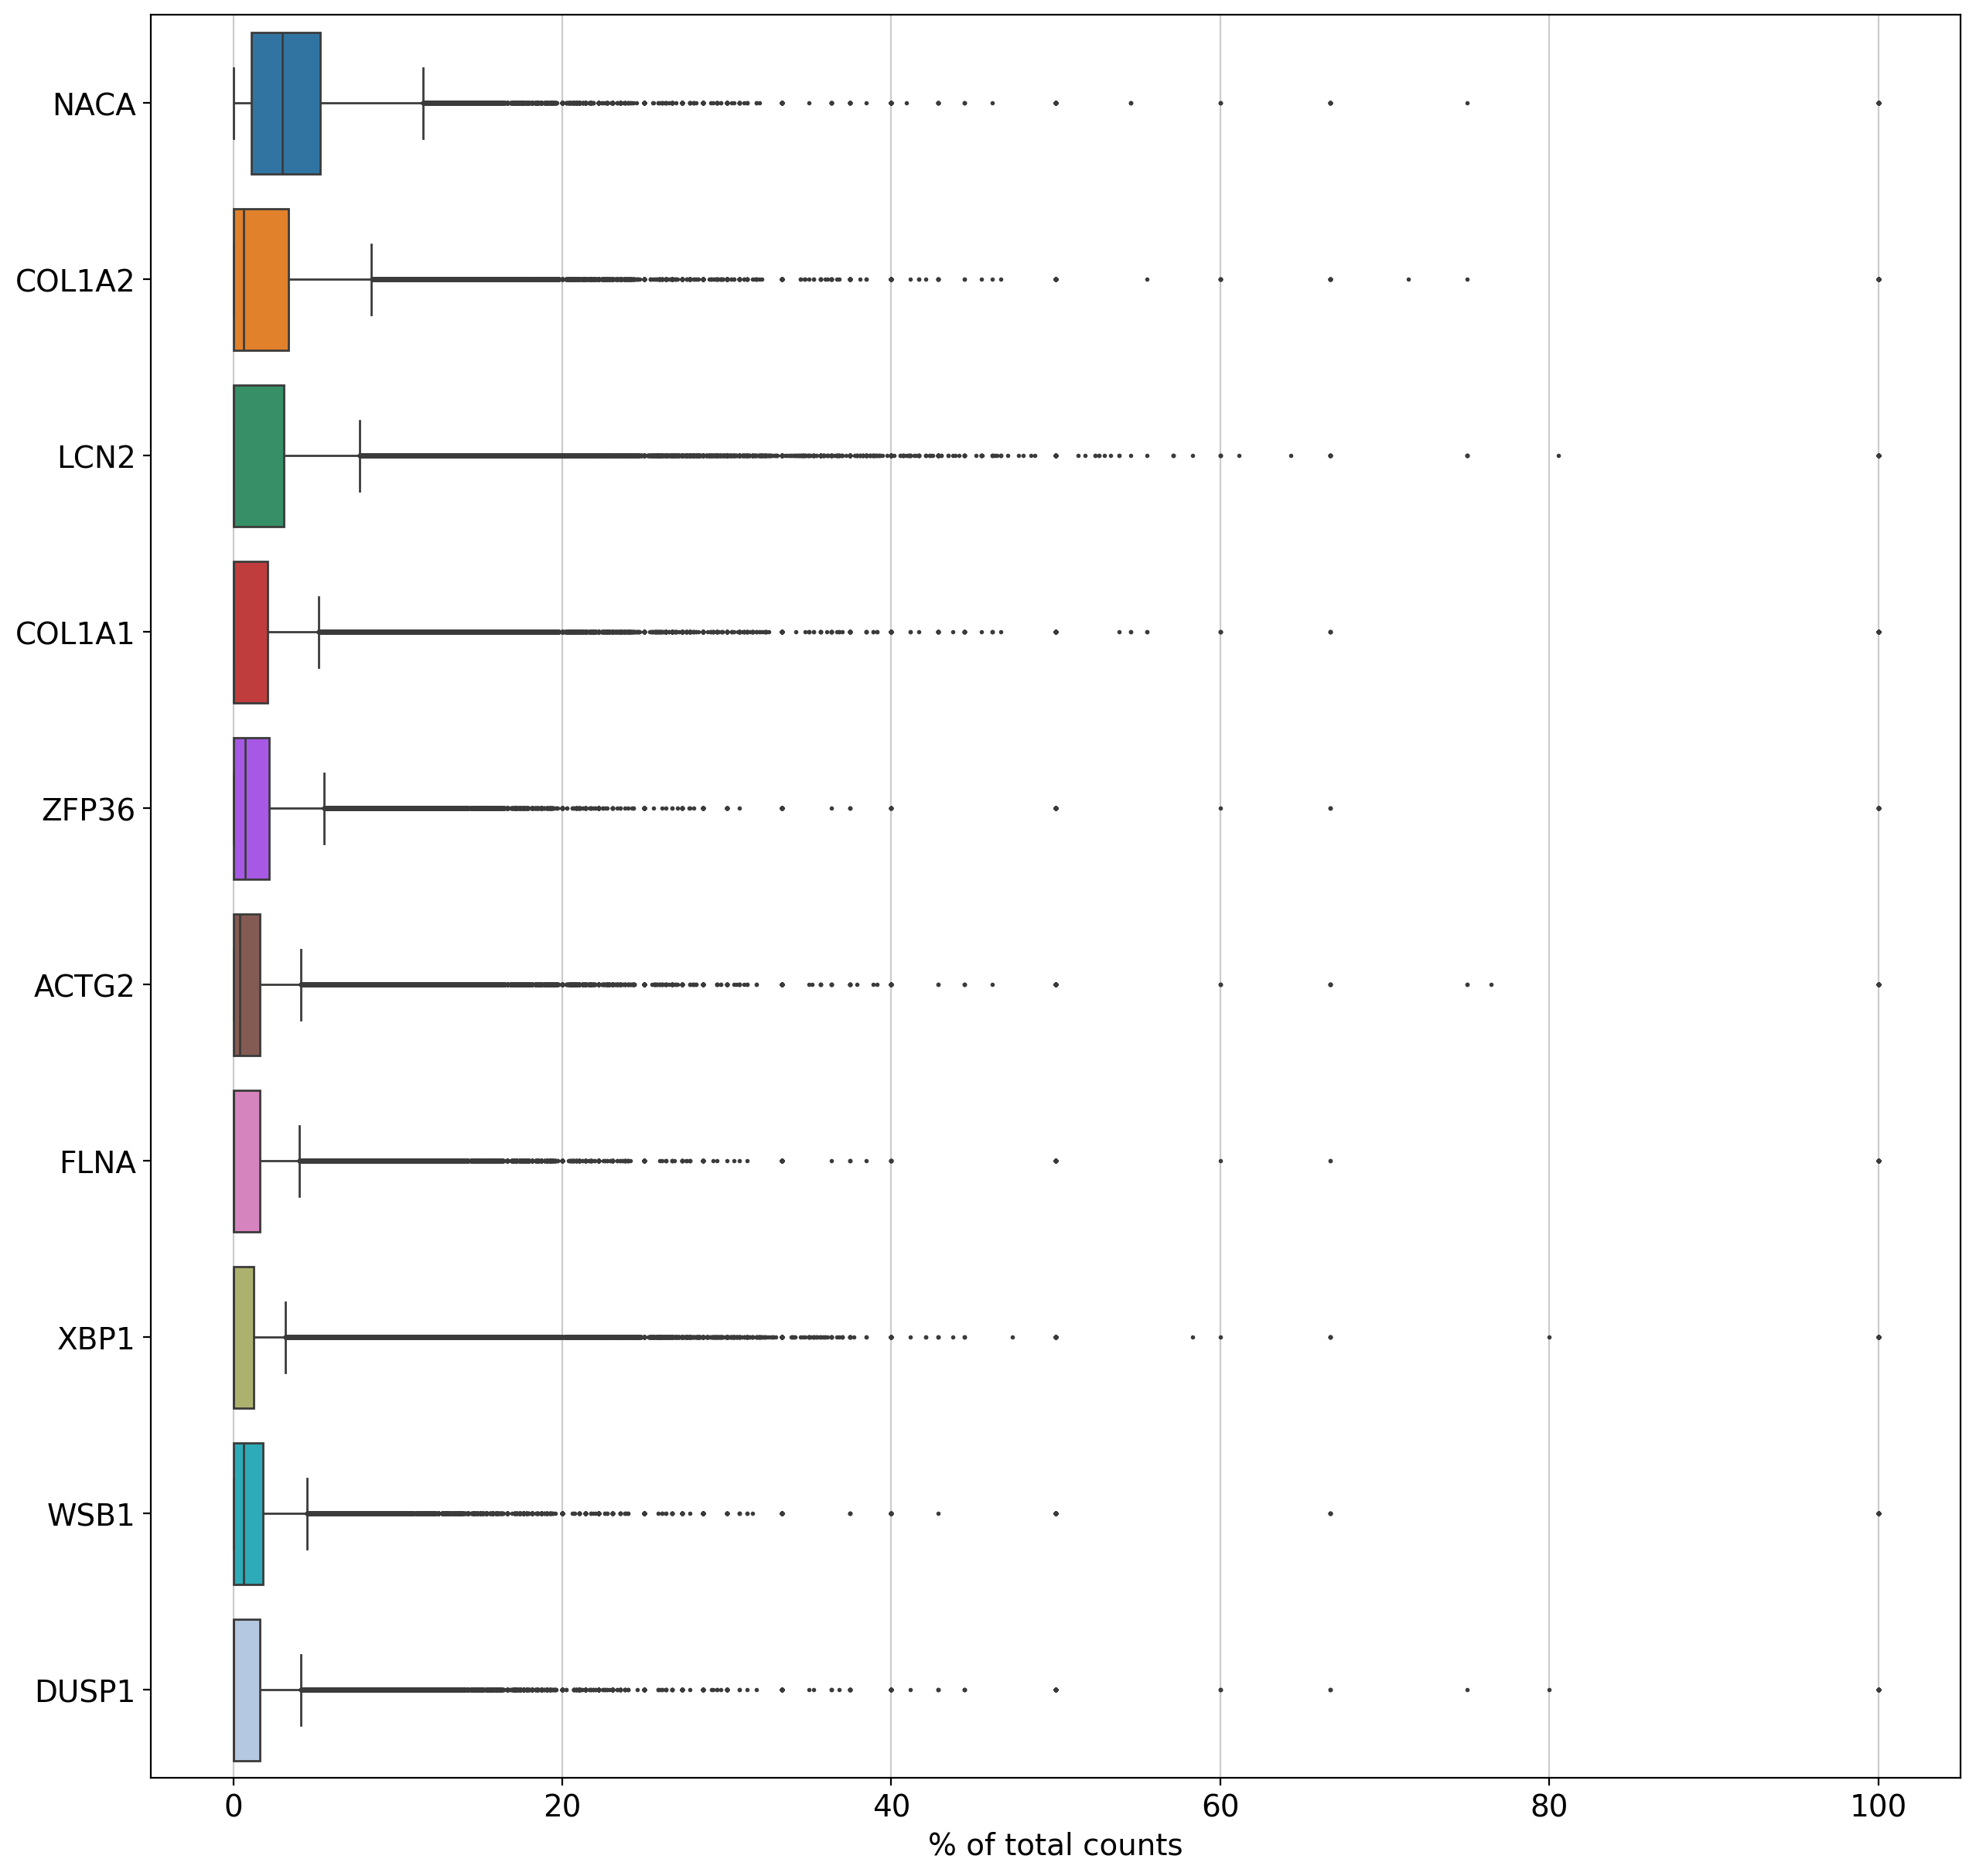



Counts: Initial


	Observations: 1038830

	Genes: 469





<<< PERFORMING QUALITY CONTROL ANALYSIS>>>

	*** Detecting Mitochondrial, Ribosomal, Hemoglobin genes...

	*** Calculating & plotting QC metrics...




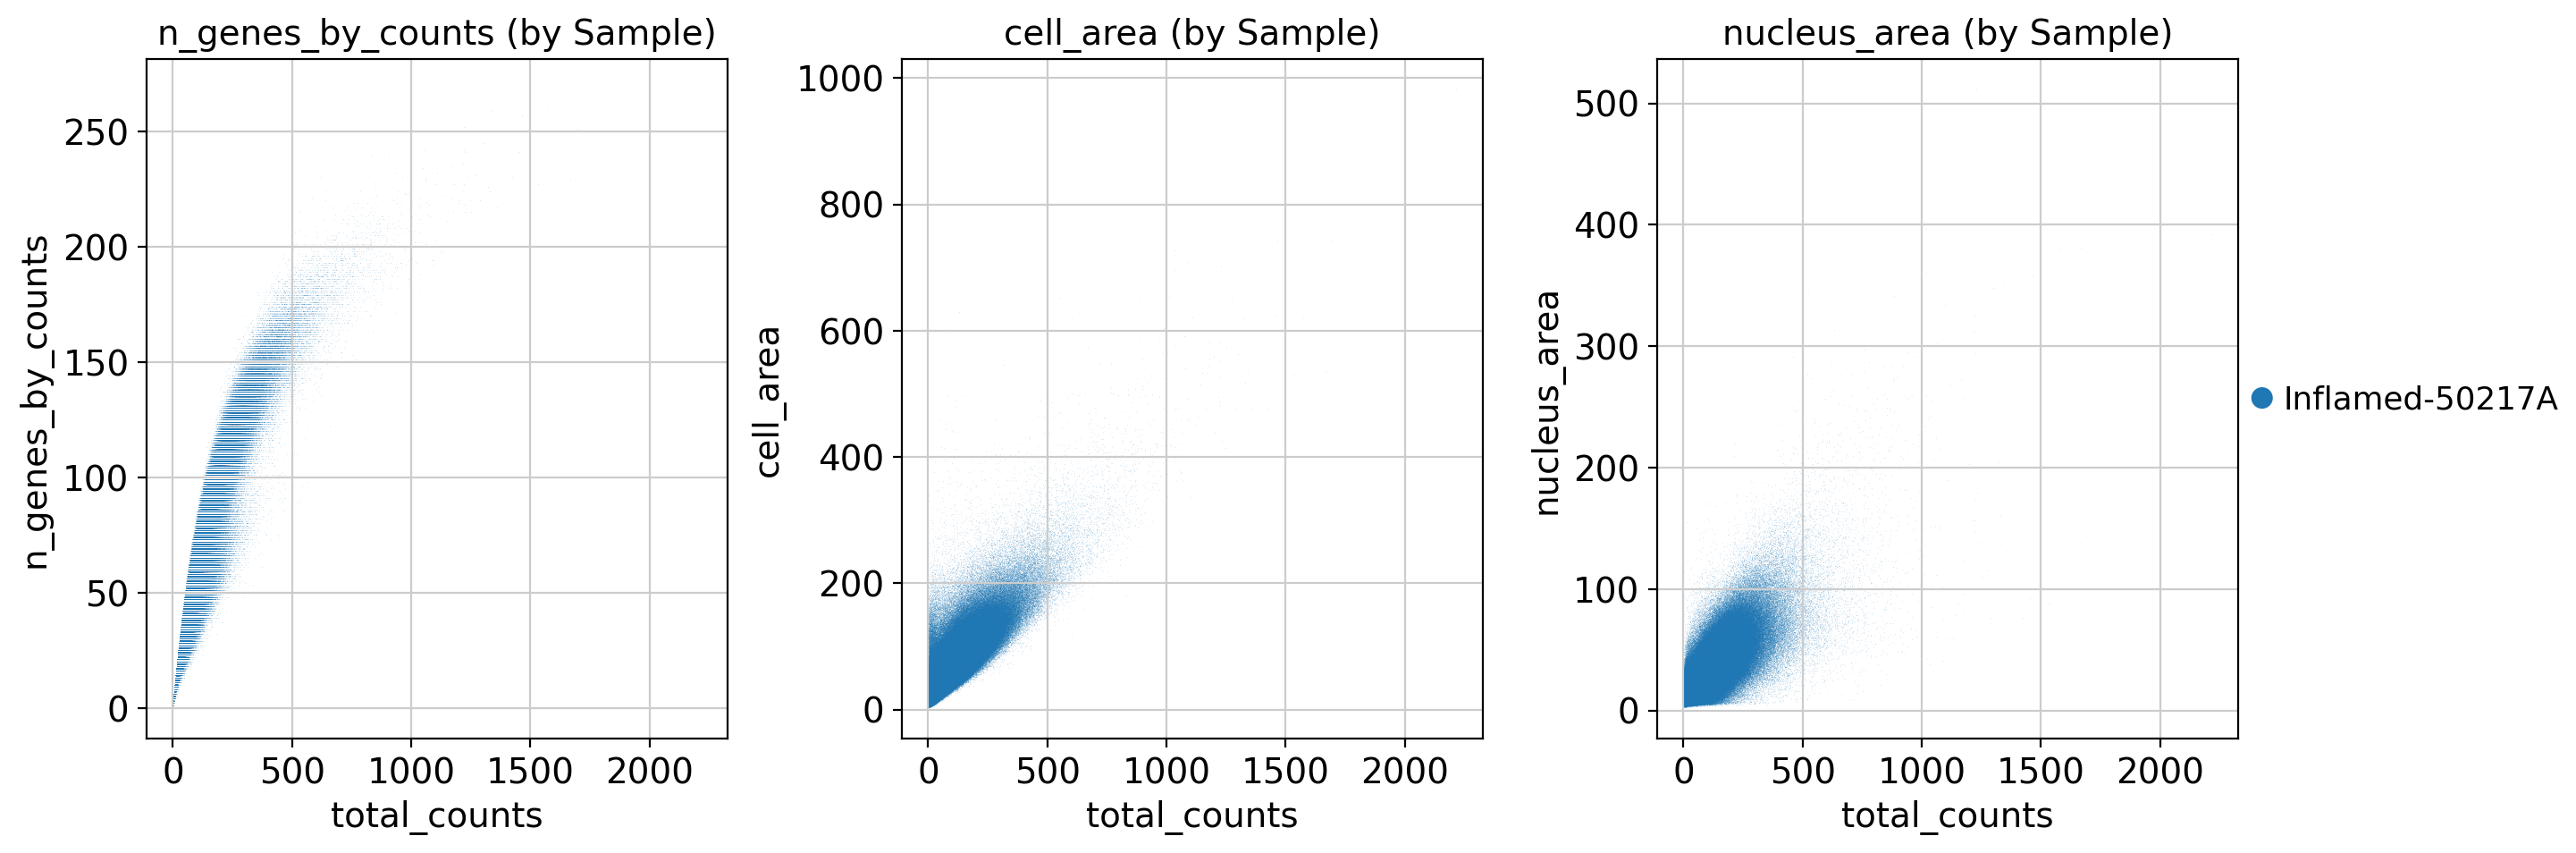


<<< FILTERING CELLS (TOO FEW GENES) & GENES (TOO FEW CELLS) >>>


Counts: Post-`min_gene`


	Observations: 1031708

	Genes: 469

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            30342.0     0.037190           0.036515              81.912921   
50%            88939.0     0.110415           0.104733              91.438541   
75%           187894.0     0.257652           0.229247              97.079214   

     total_counts  log1p_total_counts  
25%       38634.0           10.561913  
50%      114702.0           11.650102  
75%      267657.0           12.497465  





Counts: Post-`min_cell`


	Observations: 1031708

	Genes: 469

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            30342.0     0.037190           0.036515              81.912921   
50%            88939.0     0.110415           0.104733              91.438541   
75%           187894.0     0.257652           0.229247              97.079

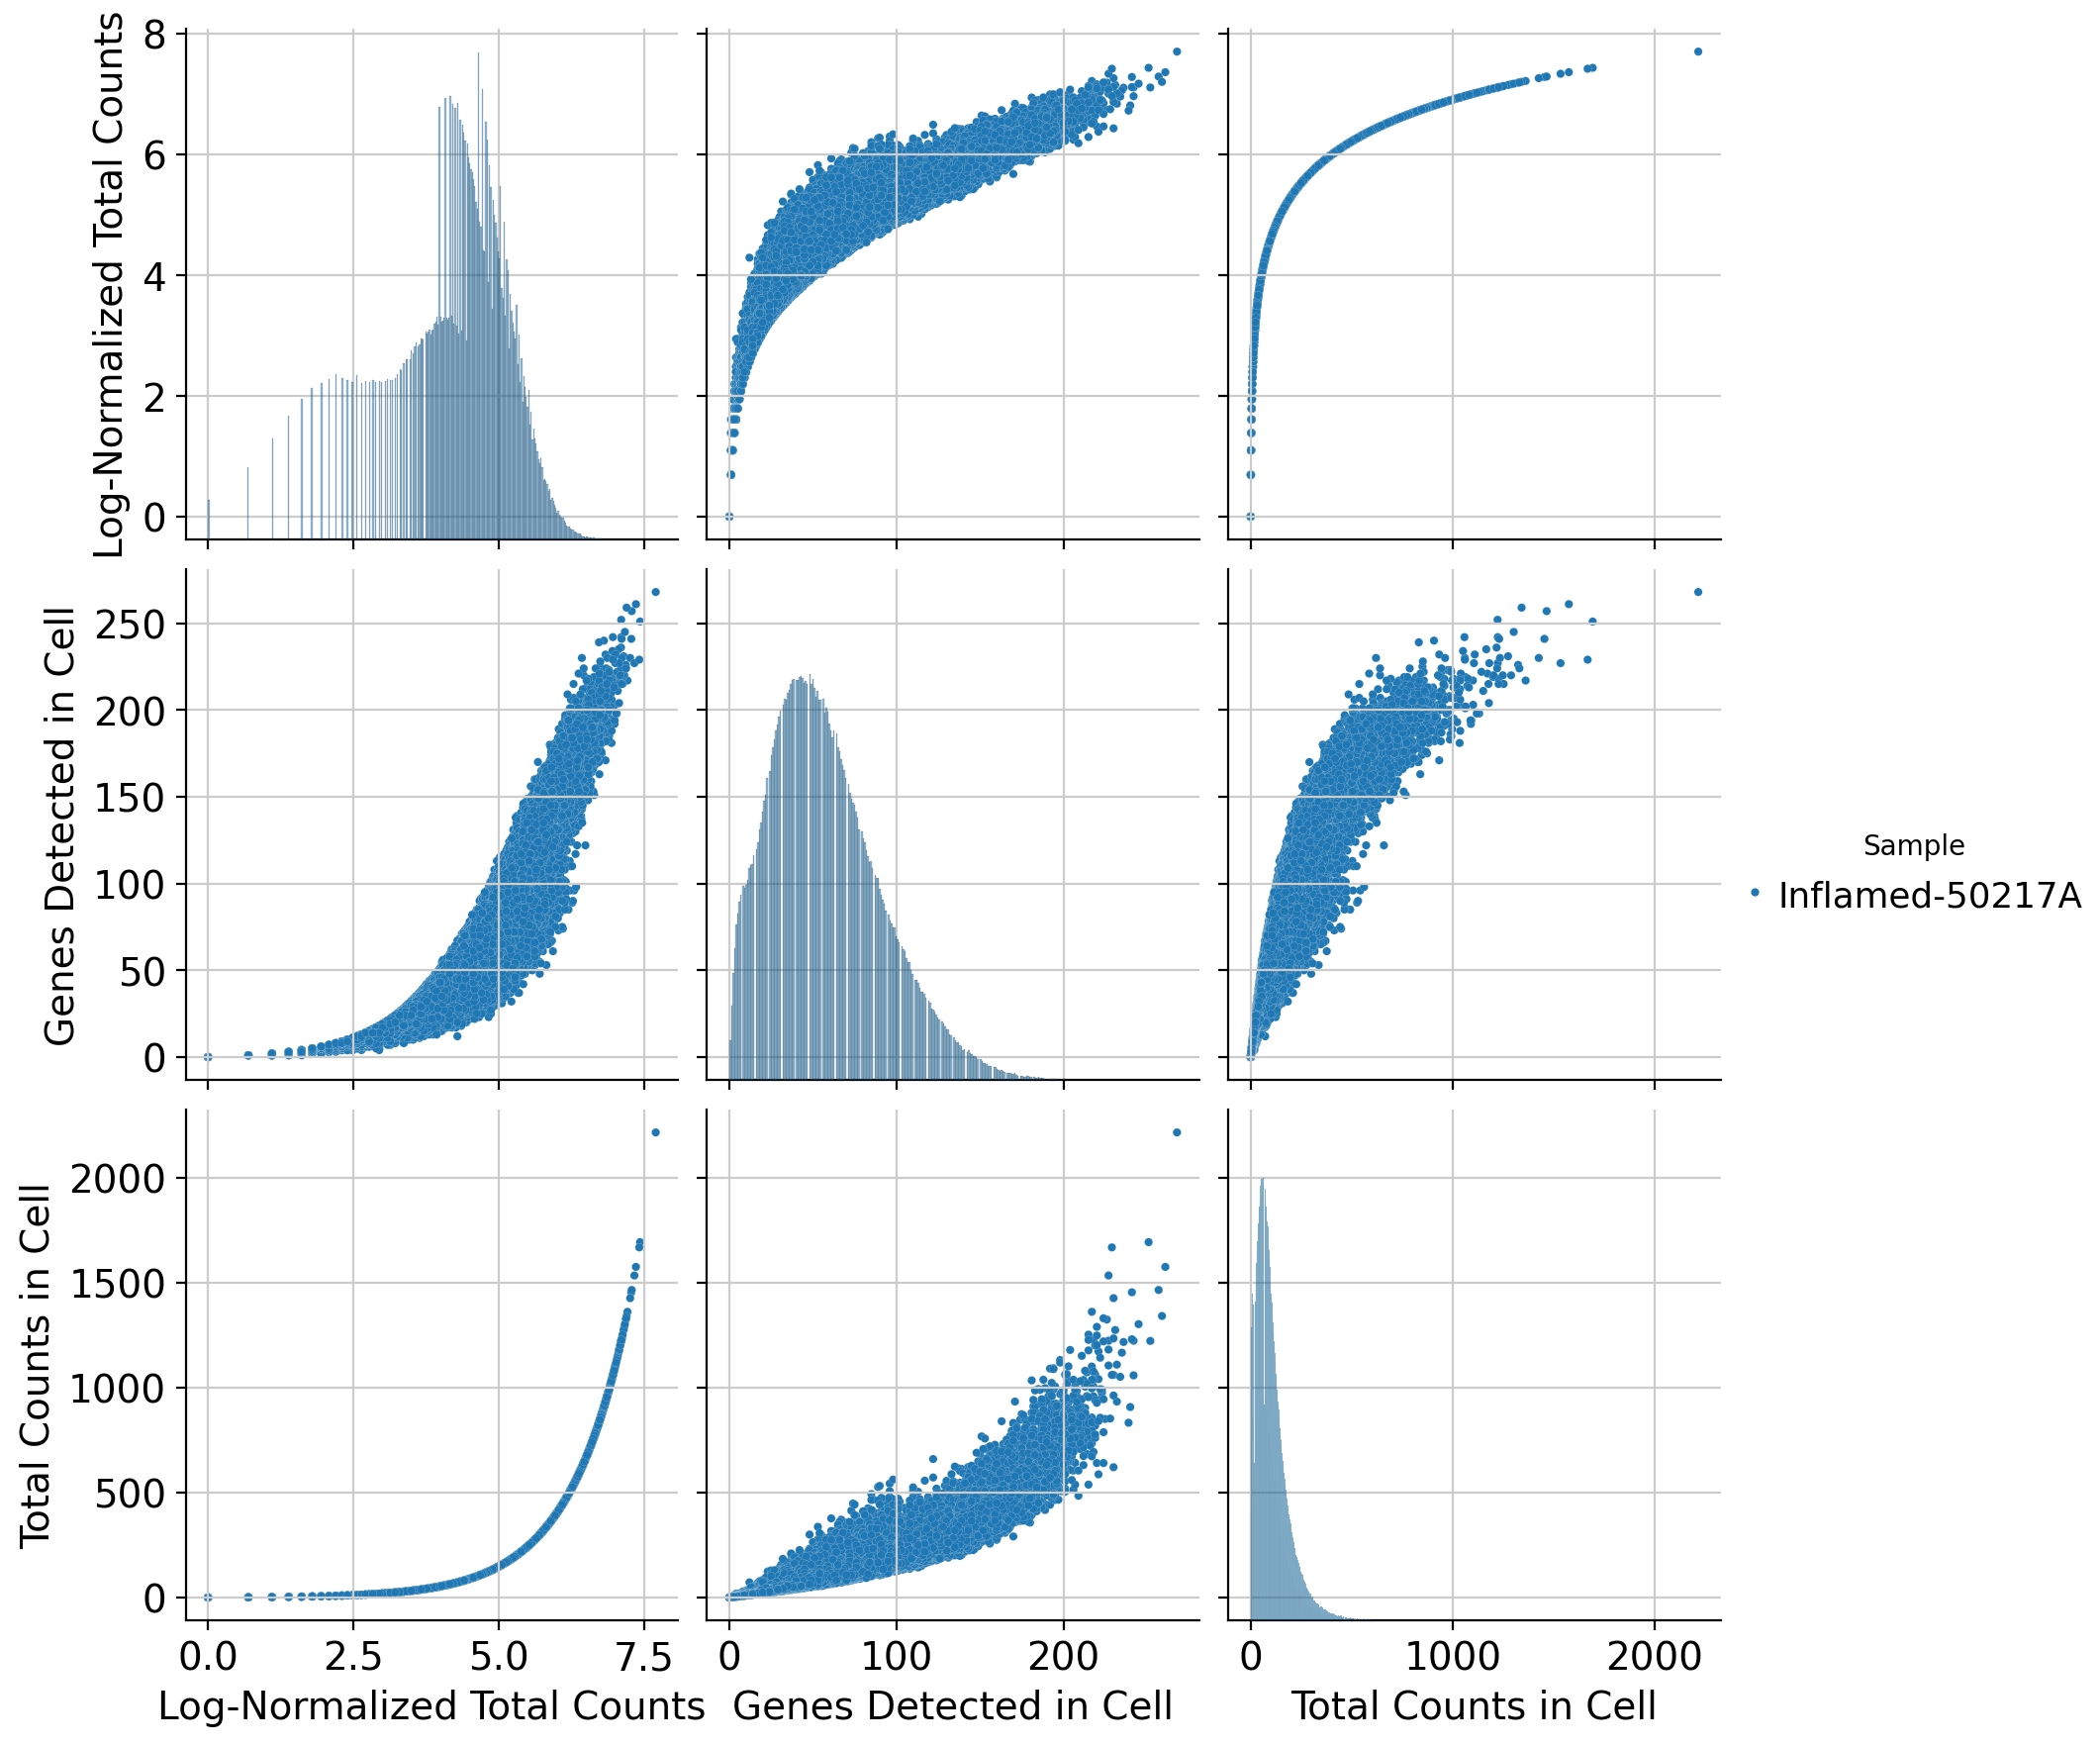

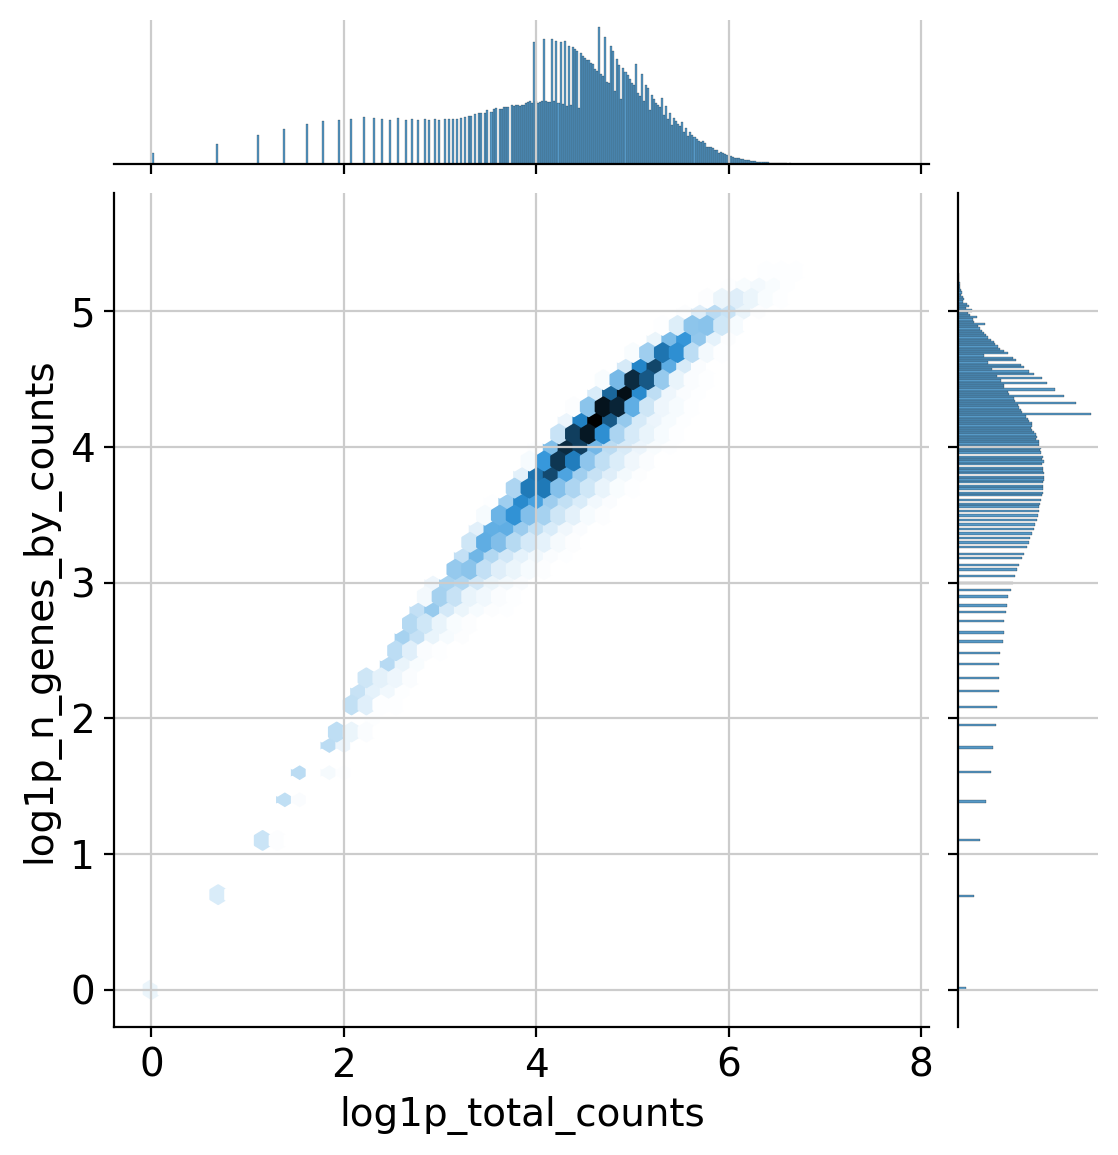

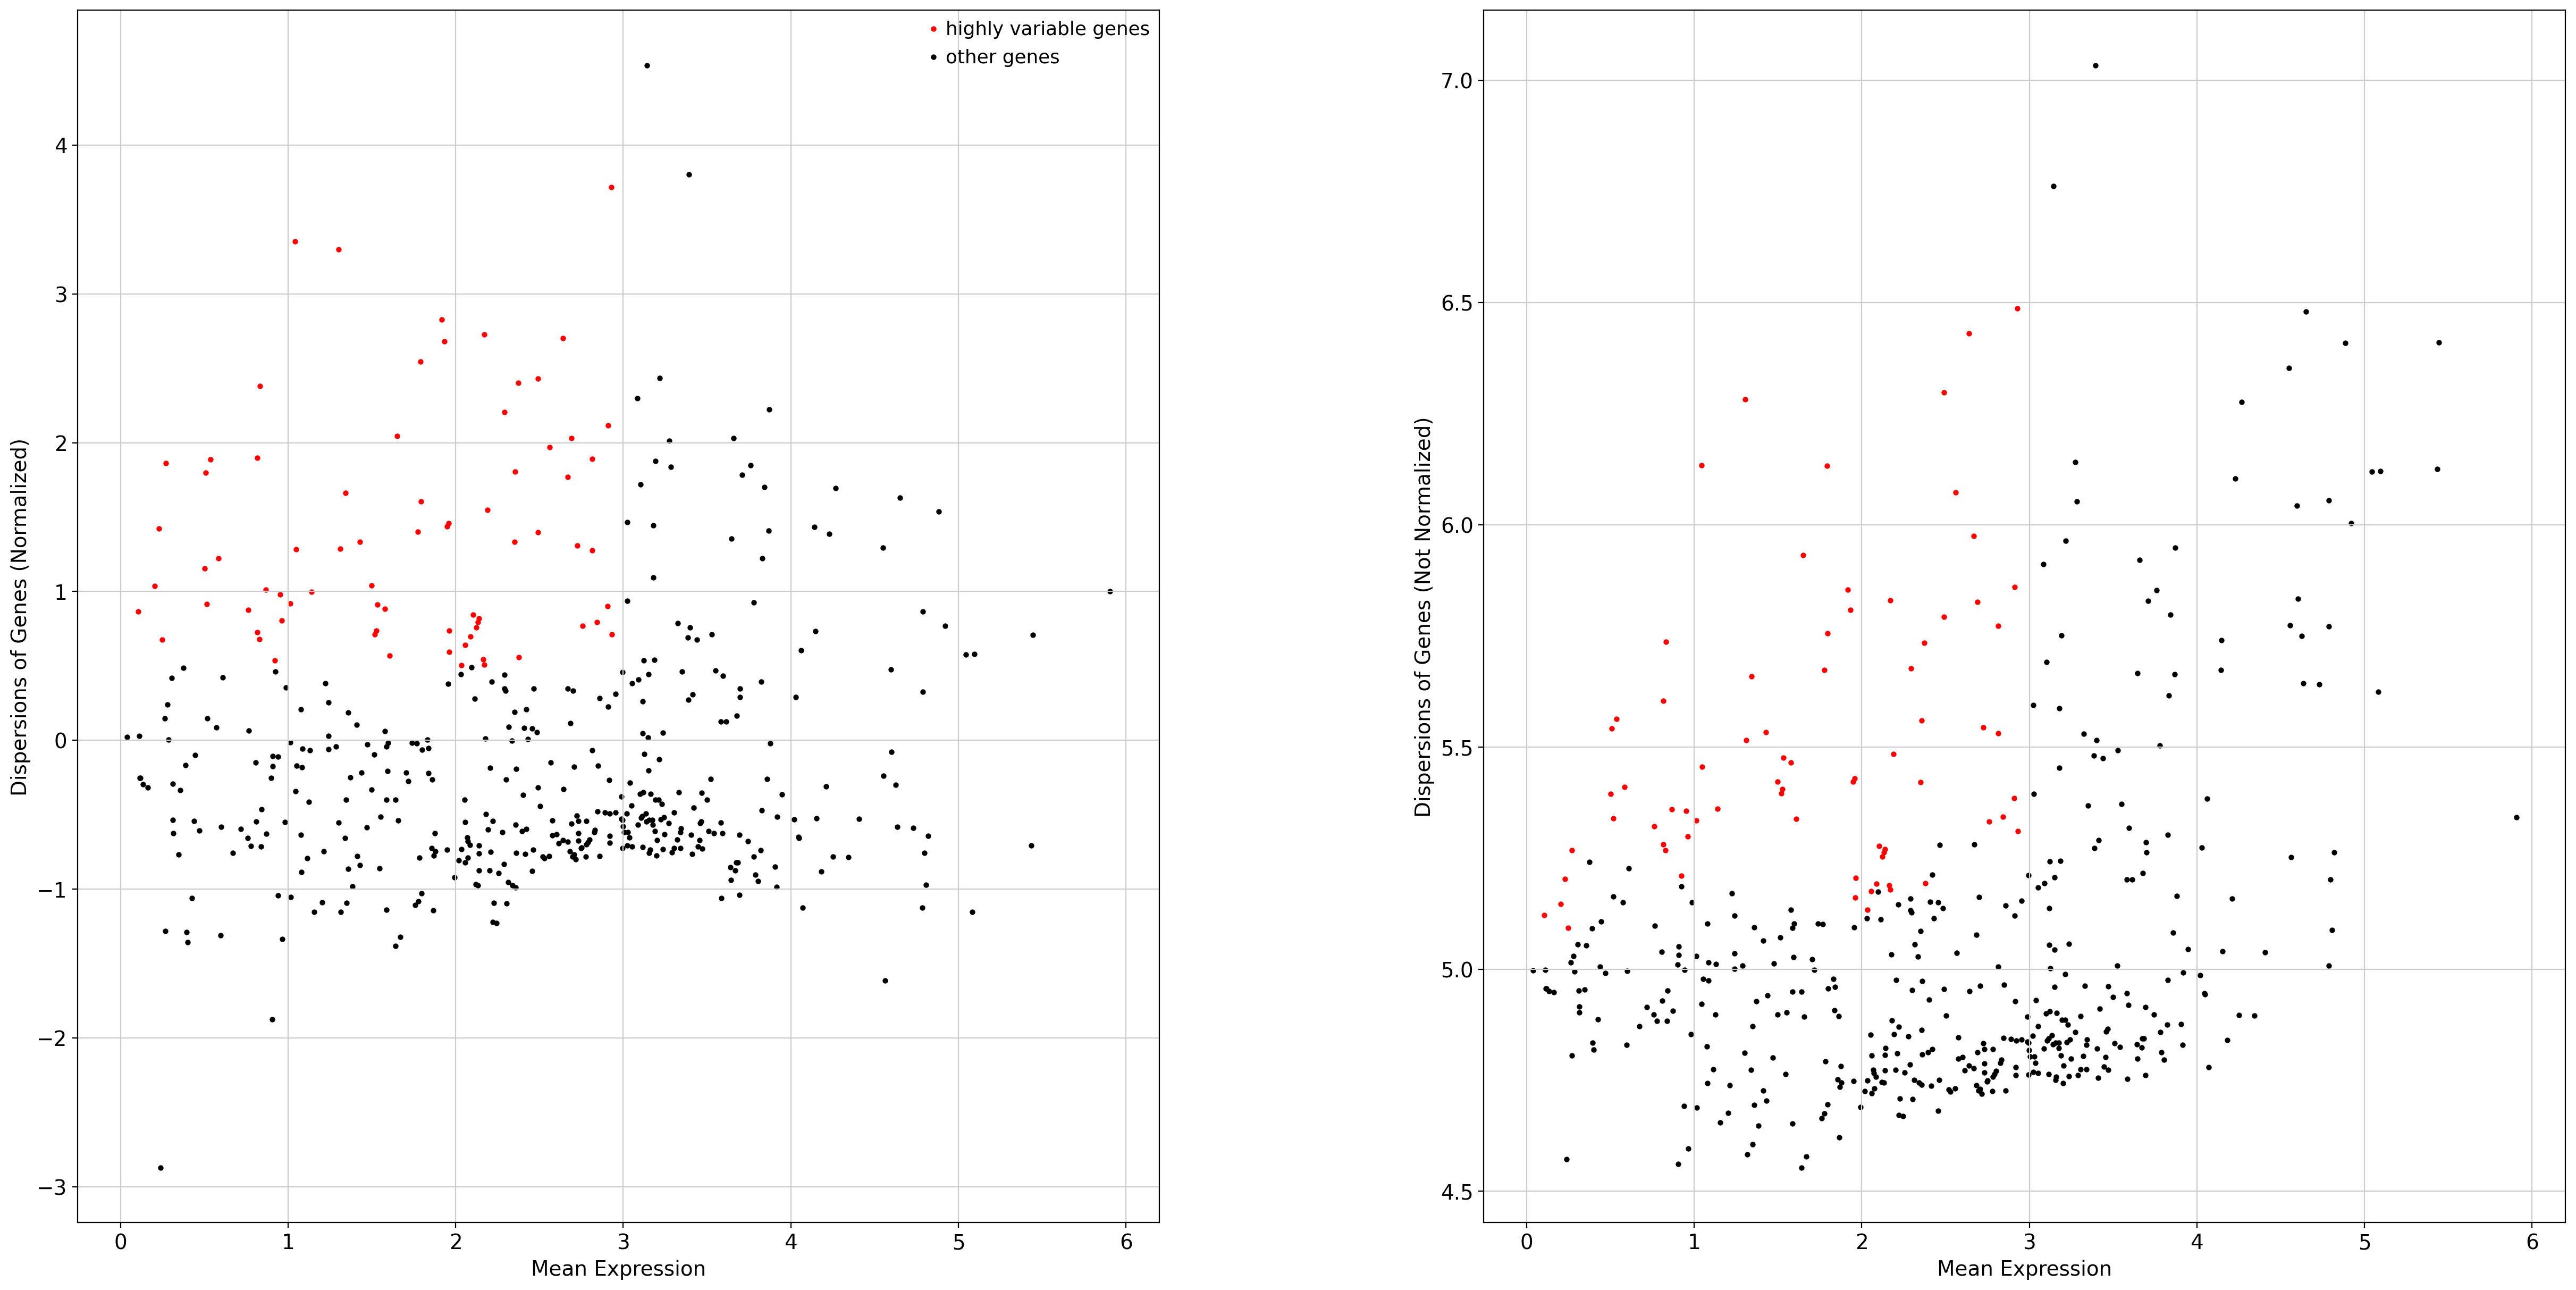


<<< NORMALIZING RAW GENE EXPRESSION >>>

	*** Scaling gene expression...

	*** Clipping maximum GEX SD to 10...

	*** Scaling => `.X` & scaled layer...


Counts: Post-Processing


	Observations: 875812

	Genes: 469

     n_cells_by_counts  mean_counts  log1p_mean_counts  pct_dropout_by_counts  \
25%            30342.0     0.037190           0.036515              81.912921   
50%            88939.0     0.110415           0.104733              91.438541   
75%           187894.0     0.257652           0.229247              97.079214   

     total_counts  log1p_total_counts   n_cells  n_counts     means  \
25%       38634.0           10.561913   28403.0   37303.0  1.531697   
50%      114702.0           11.650102   85452.0  110868.0  2.466417   
75%      267657.0           12.497465  180906.0  260329.0  3.216988   

     dispersions  dispersions_norm      mean       std  
25%     4.817365         -0.679530  0.150656  0.821648  
50%     4.975636         -0.311208  0.432222  1.336231  
75

In [3]:
%%time

for s in metadata.index.values:  # iterate samples
    print(f"\n\n{'=' * 80}\n\t\t{s}\n{'=' * 80}\n\n")
    libid = metadata.loc[s][col_sample_id_o]
    file_image = os.path.join(d_img, f"ome-tiff/{libid}.ome.tif")
    file_align = os.path.join(d_img, f"alignment/{s}/matrix.csv")  # align
    dir_data_xenium = metadata.loc[s][col_f]

    # Set Object Output Location & Check If Object Exists
    out = os.path.join(out_dir, f"{s}{suffix}.h5ad")  # object output path
    if os.path.exists(out):  # if processed object file exists...
        if kws_pp is not None:  # don't overwrite with new preprocessing
            raise ValueError(f"\n\nProcessed object already exists!\n{out}."
                             "\nSpecify different file suffix, or set "
                             "`kws_pp` to None to reload processed object.")
    elif kws_pp is None:  # if doesn't exist but pp parameters specified...
        raise ValueError(f"\n\nProcessed object doesn't exist!\n{out}.\n"
                         "Specify `kws_pp` to perform new proprocessing "
                         "or ensure processed object paths are correct.")

    # Load Data into Object (Update with Prior Preprocessed Object if Exists)
    self = cr.Spatial(dir_data_xenium, library_id=s, **kws_init)  # load data
    if all((os.path.exists(u) for u in [file_align, file_image])):
        print(f"\n\n\tAdding Image: {file_image}, {file_align}...\n\n")
        self.add_image(file_image, name=image_type, file_align=file_align)
    else:
        print(f"\n\n\tCannot Load Image; {file_image} or {file_align} "
              f"Missing...\n\n\t{file_image}\n\n")

    if os.path.exists(out) and kws_pp is None:
        self.update_from_h5ad(out)  # update with prior preprocessing

    # Add Metadata to Object
    for j in metadata.dropna(how="all", axis=1):  # add metadata to .obs
        self.rna.obs.loc[:, j] = str(metadata.loc[s][j])
    self.rna.obs.loc[:, col_object] = out  # path for processed object

    # Preprocessing
    if kws_pp is not None:
        print(f"\n\n\tPerforming Preprocessing...\n\n\t\t{kws_pp}\n\n")
        _ = self.preprocess(**kws_pp, figsize=(15, 15))  # preprocess
    else:
        print("\n\n\t***** Using Prior Processing"
              f"\n\n\t\t{self.rna.obs.iloc[[0]]}")

    # Clustering at Different Resolutions & Minimum Distances & # of PCs
    for j, x in enumerate(kws_clustering):  # iterate clustering versions

        # Variables & Output Files
        print(f"\n\n\t\t{'*' * 40}\n\t\t{x}\n\t\t{'*' * 40}\n\n")
        cct, cca = f"leiden_{x}", f"label_{x}"  # Leiden & annotation columns

        # Clustering (& Write Object) & Find Markers
        if use_prior_clustering is True and cct in self.rna.obs:
            print("\t\t\tUsing prior clustering results...")
        else:
            print(f"\t\t\tPerforming Clustering...\n\n\t\t{kws_clustering}\n")
            _ = self.cluster(**kws_clustering[x], key_added=cct, out_file=out)
        _ = self.find_markers(col_cell_type=cct, kws_plot=False)  # DEGs

        # Annotation
        if assign is not None:  # annotate by marker list
            _ = self.annotate_clusters(assign[[col_assignment[j]]],
                                       col_cell_type=cct, col_annotation=cca)

        # Plot & Write Final Object
        col_cts = [k for k in [cct, cca, ccs] if k in self.rna.obs]
        self.plot_spatial(color=col_cts)
        if out_dir is not None:
            self.write(out)

        # Create Xenium Explorer Cluster Files
        if out_dir is not None:
            osc, osm = [os.path.join(out_dir, u) for u in [
                out_subdir_cluster, out_subdir_markers]]
            print(f"\n\t\t\tWriting Explorer & Marker Files: {osc}, {osm}...")
            for c in col_cts:  # Explorer
                self.write_clusters(
                    osc, col_cell_type=c, overwrite=True,
                    file_prefix=f"{self._library_id}__", n_top=osm)

        # Multi-Page PDF Cluster Plots
        if out_dir_plot is not None:
            print(f"\n\t\t\tPlotting Clusters: {out_dir_plot}...")
            for c in col_cts:
                self.plot_clusters(
                    col_cell_type=c, multi_pdf=True, out_dir=os.path.join(
                        out_dir_plot, self._library_id, f"{c}{suffix}.pdf"))

    # Spatially-Informed Clustering (Optional)
    if kws_clustering_spatial is not None:
        print(f"\n\n\tPerforming Spatial Clustering...")
        ccs = f"leiden_spatial_{suffix_clustering_spatial}"
        _ = s.cluster_spatial(key_added=ccs, **kws_clustering_spatial)
        _ = s.find_markers(col_cell_type=ccs, kws_plot=False)
        if out_dir is not None:
            self.write(out)